# VGG
[VGG论文 Arxiv](https://arxiv.org/abs/1409.1556)

## 主要贡献

1. 在神经网络结构中使用了块。VGG将一系列卷积核组装成块，后接激活函数和最大池化层。原始VGG论文中，作者使用$3 \times 3$卷积核， $ padding = 1$，步长为1（保持宽度和高度），使用 $ReLU$激活函数和池化窗口$2 \times 2$，步长为2的最大池化层（分辨率减半）。

    VGG都是五个卷积Block，每个Block内部的输入输出通道数相同。可以通过一个元组调整每个Block的卷积层数和每个Block的输出通道数。 

2. 提出小卷积核效果比大卷积核更好

## VGG结构

![从Lenet到VGG](./img/vgg.svg#pic_center)
![不同规模的VGG](./img/DifferentVGG.png#pic_center)

# Pytorch 实现VGG

In [8]:
import torch
import torch.nn.functional as F
from torchvision import transforms,datasets
from torch.utils import data
from torch import nn
from torchsummary import summary

def vgg_blocks(num_conv, in_channels, out_channels):
    layers = []
    for i in range(num_conv):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3, padding = 1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(2,2))
    return layers

# VGG11配置
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

class Vgg(nn.Module):
    def __init__(self,in_channels,num_classes,conv_arch):
        super(Vgg,self).__init__()
        conv_blocks = []
        for (num_conv, out_channels) in conv_arch:
            conv_blocks.extend(vgg_blocks(num_conv,in_channels,out_channels))
            in_channels = out_channels

        self.backbone = nn.Sequential(*conv_blocks,
                                    nn.Flatten(),
                                    nn.Linear(out_channels*7*7,4096),
                                    nn.ReLU(),
                                    nn.Dropout(p = 0.5),
                                    nn.Linear(4096,4096),
                                    nn.ReLU(),
                                    nn.Dropout(p = 0.5),
                                    nn.Linear(4096,num_classes))

    def forward(self,x):
        x = self.backbone(x)
        return x

net = Vgg(3,10,conv_arch)
summary(net,(3,224,224),device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

#  检验前向传播

In [3]:
X = torch.rand(size = (1,1,224,224) , dtype = torch.float32)
print(X.shape)
typeList = [nn.Conv2d, nn.Linear, nn.MaxPool2d, nn.Flatten]
for layer in list(net.children())[0]:
    if type(layer) in typeList:
        X = layer(X)
        print(type(layer), X.shape)


torch.Size([1, 1, 224, 224])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([1, 64, 224, 224])
<class 'torch.nn.modules.pooling.MaxPool2d'> torch.Size([1, 64, 112, 112])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([1, 128, 112, 112])
<class 'torch.nn.modules.pooling.MaxPool2d'> torch.Size([1, 128, 56, 56])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([1, 256, 56, 56])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([1, 256, 56, 56])
<class 'torch.nn.modules.pooling.MaxPool2d'> torch.Size([1, 256, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([1, 512, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([1, 512, 28, 28])
<class 'torch.nn.modules.pooling.MaxPool2d'> torch.Size([1, 512, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([1, 512, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> torch.Size([1, 512, 14, 14])
<class 'torch.nn.modules.pooling.MaxPool2d'> torch.Size([1, 512, 7, 7])
<class 'torch.nn.modules.flatten.Flatten'> torch.Size([

# 检验Cifar100数据集

Files already downloaded and verified
Files already downloaded and verified
<class 'torch.Tensor'> torch.Size([3, 224, 224])


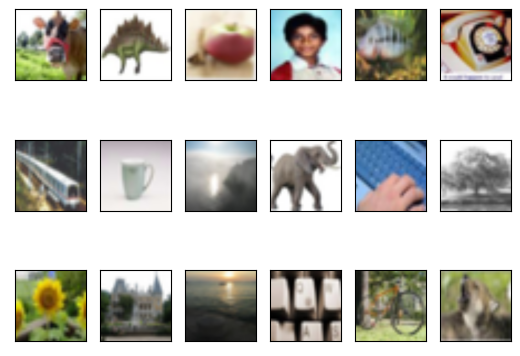

In [6]:
import matplotlib.pyplot as plt

trans = transforms.Compose({
    transforms.Resize(224),
    transforms.ToTensor()
})

cifar_100_train = datasets.CIFAR100('../../../DataSets/',train = True, transform= trans, download= True)
cifar_100_test = datasets.CIFAR100('../../../DataSets/',train = False, transform= trans, download= True)

X, y =next(iter(data.DataLoader(cifar_100_train,batch_size = 18)))

def show_img(imgs,num_rows,num_cols,titles = None,scale = 1.5):
    plt.figure(num_rows*num_cols*scale)
    axes = []
    for i in range(num_cols*num_rows):
        axe = plt.subplot(num_rows,num_cols, i+1)
        axes.append(axe)

    for i, (axe, img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            axe.imshow(img.permute(1,2,0).numpy())
        else:
            axe.imshow()
        axe.axes.get_xaxis().set_visible(False)
        axe.axes.get_yaxis().set_visible(False)
        if titles:
            axe.set_title(titles[i])
show_img(X,3,6)

print(type(cifar_100_train[0][0]), cifar_100_train[0][0].shape)

In [ ]:
# 超参数
lr = 0.1
num_epochs = 1
batch_size = 64

device = ("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

